In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from utils import box_plot, filter_df, vectorizers_order2, line_plot, heatmap_plot, corr_plot
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

input_dir = '../logs/'
case_order = [f'D{i}' for i in range(1, 11)]

# Real Data

## Vectorization

In [5]:
with open(input_dir+'vectorization_real.txt') as f:
    lines = []
    for line in f.readlines():
        line = json.loads(line)
        
        lines.append((line['dir'], line['vectorizer'], line['init_time'], line['time'], line['file'],
                      line['column']['name'], line['memory']['process']['rss'],
                      line['memory']['total']['used']))
    
vec_df = pd.DataFrame(lines, columns=['Case', 'Vectorizer', 'Init Time', 'Total Time', 'File',
                                        'Column', 'Memory Process', 'Memory Total'])

vec_df['Case'] = vec_df['Case'].apply(lambda x: x.split('(')[0])
vec_df['Vectorizer'] = vec_df['Vectorizer'].apply(lambda x: x[0]+x[-1]).str.upper()

#fig, axes = plt.subplots(nrows=1, ncols=1)
#box_plot(vec_df, 'Vectorizer', 'Total Time', ['Case', 'File', 'Column'], 0, axes, "", order=vectorizers_order2, yscale='log', ylabel='Total Time (sec) (log)')
#plt.savefig(f'../plots/vectorization_real_time.pdf', bbox_inches='tight')

### Tables

In [6]:
vec_df2 = vec_df.loc[vec_df.Column == 'aggregate value'].reset_index(drop=True)
vec_df2.File = vec_df2.File.apply(lambda x: x[:-4])

vec_df21 = vec_df2.loc[vec_df2['Case'] != 'D5_D6_D7']
vec_df22 = vec_df2.loc[vec_df2['Case'] == 'D5_D6_D7']

cases = {'D5': ('imdb', 'tvdb'), 'D6': ('tmdb', 'tvdb'), 'D7': ('imdb', 'tmdb'),}

for k, v in cases.items():
    for vv in v:
        temp = vec_df22.loc[vec_df22.File == vv].copy()
        temp['Case'] = k
        vec_df21 = pd.concat([vec_df21, temp])
vec_df2 = vec_df21.groupby(['Case', 'Vectorizer'])['Total Time'].sum()
vec_df2 = vec_df2.unstack()
vec_df2 = vec_df2.reset_index(drop=False)
vec_df2['Time'] = 'Vectorization'
#vec_df2 = vec_df2.set_index(['Case', 'Time'])

#tables_times = pd.concat([vec_df2, block_df2, match_df2])
tables_times = vec_df2
tables_times = tables_times.set_index(['Case', 'Time'])
#tables_times.sort_index()
tables_times = tables_times.loc[case_order][vectorizers_order2]
tables_times = tables_times.round(2)

print(tables_times.to_latex())

\begin{tabular}{llrrrrrrrrrrrr}
\toprule
    & Vectorizer &    WC &     FT &    GE &     BT &     AT &     RA &     DT &     XT &     ST &      S5 &     SA &     SM \\
Case & Time &       &        &       &        &        &        &        &        &        &         &        &        \\
\midrule
D1 & Vectorization &  0.02 &   0.17 &  0.18 &   2.17 &   2.27 &   2.14 &   1.27 &   3.49 &   1.04 &    2.87 &   0.66 &   0.77 \\
D2 & Vectorization &  0.13 &   1.54 &  0.23 &   2.86 &   2.35 &   2.28 &   2.11 &   3.24 &   3.35 &   10.56 &   1.78 &   1.37 \\
D3 & Vectorization &  0.87 &   9.58 &  0.44 &  10.12 &   6.51 &   6.18 &   8.60 &   7.77 &  10.22 &   38.35 &   5.69 &   3.26 \\
D4 & Vectorization &  0.21 &   2.42 &  0.29 &   5.74 &   4.95 &   5.02 &   3.94 &   7.11 &   5.00 &   16.40 &   2.77 &   2.15 \\
D5 & Vectorization &  0.37 &   3.77 &  0.41 &  12.98 &  12.18 &  12.01 &   8.45 &  18.04 &  10.63 &   36.09 &   6.02 &   4.53 \\
D6 & Vectorization &  0.56 &   5.47 &  0.48 &  14.95 &  

/tmp/ipykernel_59161/3963816580.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tables_times.to_latex())


In [7]:
init_times = vec_df21.groupby('Vectorizer')['Init Time'].mean()
init_times = pd.DataFrame(init_times).T
init_times = init_times[vectorizers_order2]
init_times = init_times.round(2)

print(init_times.to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
Vectorizer &     WC &      FT &    GE &    BT &    AT &    RA &    DT &    XT &    ST &    S5 &    SA &    SM \\
\midrule
Init Time &  31.21 &  155.73 &  5.77 &  4.48 &  3.98 &  5.06 &  4.24 &  5.76 &  8.64 &  9.63 &  9.02 &  8.17 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_59161/2379227987.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(init_times.to_latex())


## Blocking

In [8]:
f_sch = ('Columns', 'ne', 2)
f_agn = ('Columns', 'eq', 2)
f_q2i = ('Direction', 'eq', 'q2i')
f_i2q = ('Direction', 'eq', 'i2q')
f_exa = ('Exact', 'eq', 'exact')
f_app = ('Exact', 'eq', 'approx')
f_k = ('k', 'eq', 10)

block_df = pd.read_csv('../logs/blocking_recall_euclidean_real.csv')

block_df['Vectorizer'] = block_df['Vectorizer'].apply(lambda x: x[0]+x[-1]).str.upper()
block_df['F1'] = block_df.apply(lambda x: 2*x['Recall']*x['Precision'] / (x['Recall']+x['Precision']) if x['Recall']+x['Precision'] > 0 else 0, axis=1)
print(block_df.shape)

tuples = [('D1', 0), ('D2', 0), ('D3', 0), ('D4', 0), ('D5', 1), ('D6', 0), ('D7', 0), ('D8', 0), ('D9', 0), ('D10', 0), 
          ('D1', 2), ('D2', 2), ('D3', 2), ('D4', 2), ('D5', 2), ('D6', 2), ('D7', 2), ('D8', 2), ('D9', 2), ('D10', 2)]

block_df = block_df.loc[block_df.apply(lambda x: (x['Case'], x['Columns']) in tuples, axis=1)]
print(block_df.shape)
block_df = filter_df(block_df, [f_i2q, f_exa])
print(block_df.shape)
block_df

(4320, 11)
(2880, 11)
(720, 11)


,Unnamed: 0,Case,Columns,Vectorizer,k,Direction,Exact,Recall,Precision,Time,F1
1,1,D1,0,WC,1,i2q,exact,0.674157,0.026596,0.011508,0.051173
5,5,D1,0,WC,5,i2q,exact,0.741573,0.005851,0.017584,0.011611
9,9,D1,0,WC,10,i2q,exact,0.741573,0.002926,0.026908,0.005828
13,25,D1,0,GE,1,i2q,exact,0.876404,0.034574,0.010692,0.066525
17,29,D1,0,GE,5,i2q,exact,0.887640,0.007004,0.017359,0.013897
...,...,...,...,...,...,...,...,...,...,...,...
4289,329,D10,0,FT,5,i2q,exact,0.364213,0.071840,0.897619,0.120009
4293,333,D10,0,FT,10,i2q,exact,0.372392,0.036727,1.046583,0.066860
4309,349,D10,2,FT,1,i2q,exact,0.058260,0.057458,0.820266,0.057856
4313,353,D10,2,FT,5,i2q,exact,0.086953,0.017151,0.855245,0.028651


### Heatmap

(240, 11)


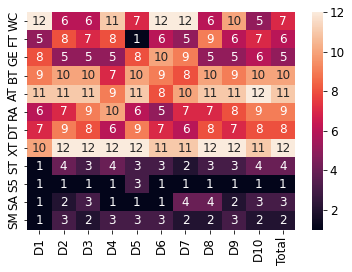

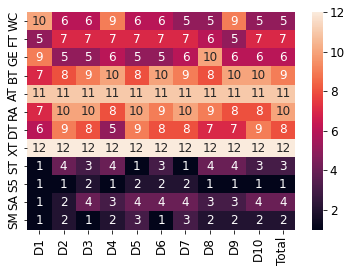

In [9]:
plt.rcParams.update({'font.size': 12, 'font.weight': 'normal'})
block_df2 = filter_df(block_df, [f_k])
print(block_df2.shape)

block_df21 = filter_df(block_df2, [f_sch])
heatmap_plot(block_df21, 'Case', 'F1', 'Vectorizer', order=case_order, legend=True)
plt.savefig(f'../plots/blocking_real_vec_exact_sch_heat.pdf', bbox_inches='tight')
plt.show()

block_df22 = filter_df(block_df2, [f_agn])
heatmap_plot(block_df22, 'Case', 'F1', 'Vectorizer', order=case_order, legend=True)
plt.savefig(f'../plots/blocking_real_vec_exact_agn_heat.pdf', bbox_inches='tight')

### Correlation

(120, 11)


/home/alex/Desktop/repos/Embedings4ER/jupyter/utils.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Total'] = df2.apply(lambda x: (x[col_columns], x[col_values]), axis=1)


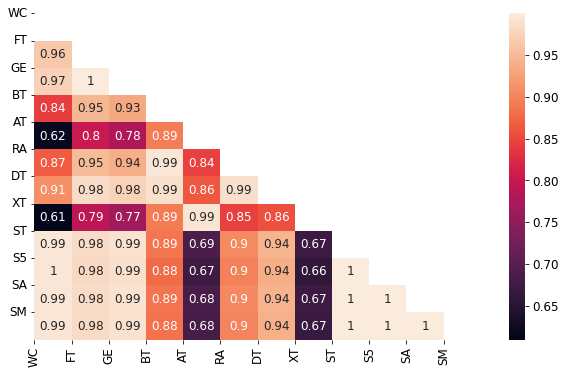

(120, 11)


/home/alex/Desktop/repos/Embedings4ER/jupyter/utils.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Total'] = df2.apply(lambda x: (x[col_columns], x[col_values]), axis=1)


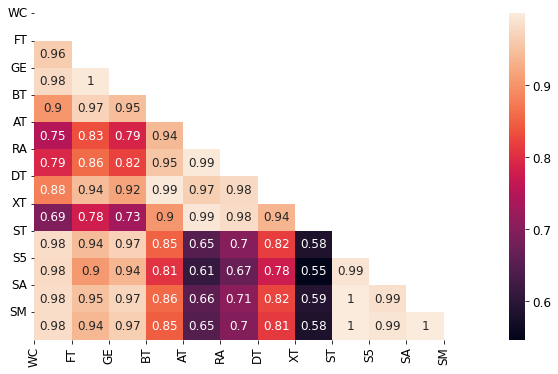

In [10]:
plt.rcParams.update({'font.size': 12, 'font.weight': 'normal'})
block_df2 = filter_df(block_df, [f_sch, f_k])
print(block_df2.shape)

corr_plot(block_df2, 'Case', 'F1', 'Vectorizer', order=vectorizers_order2, figsize=(10, 6))
plt.savefig(f'../plots/blocking_real_vec_exact_sch_corr.pdf', bbox_inches='tight')
plt.show()

block_df2 = filter_df(block_df, [f_agn, f_k])
print(block_df2.shape)

corr_plot(block_df2, 'Case', 'F1', 'Vectorizer', order=vectorizers_order2, figsize=(10, 6))
plt.savefig(f'../plots/blocking_real_vec_exact_agn_corr.pdf', bbox_inches='tight')

### Plots

(360, 11)


/tmp/ipykernel_59161/3896048008.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


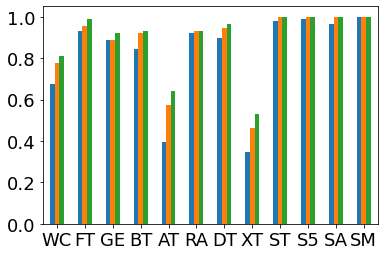

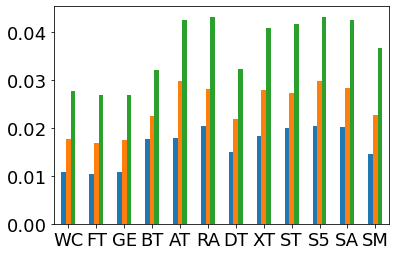

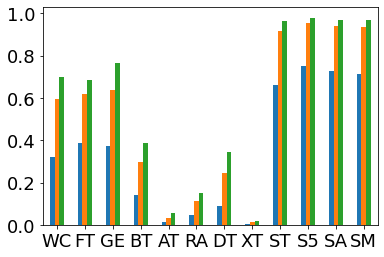

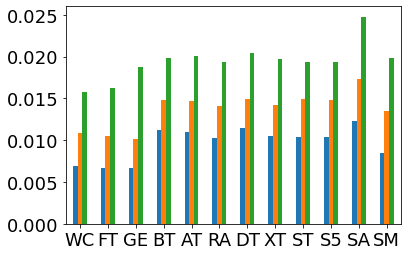

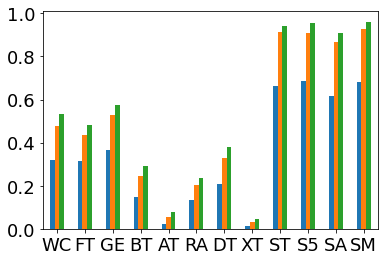

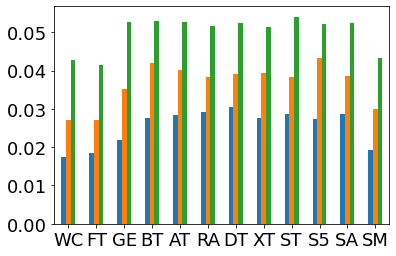

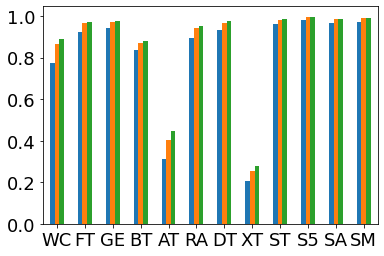

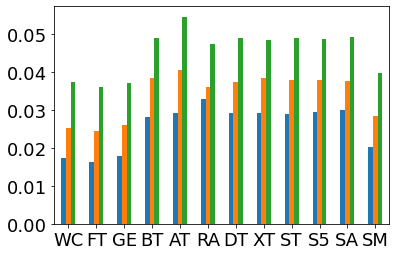

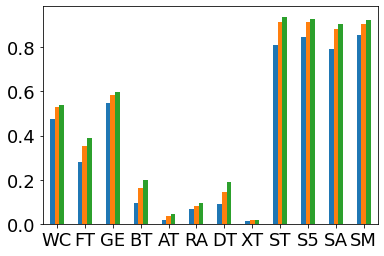

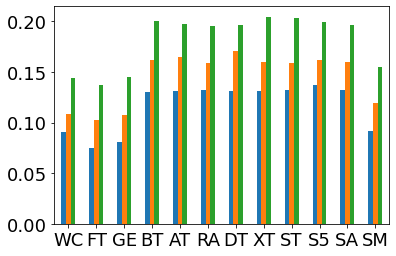

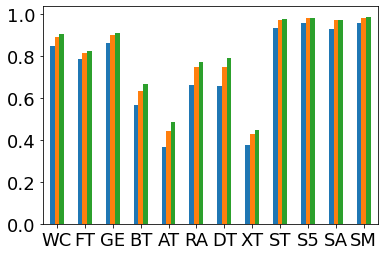

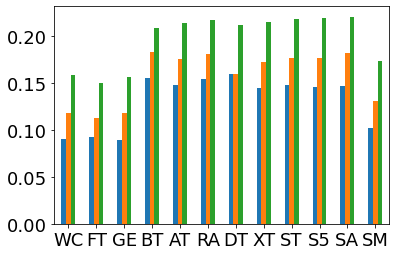

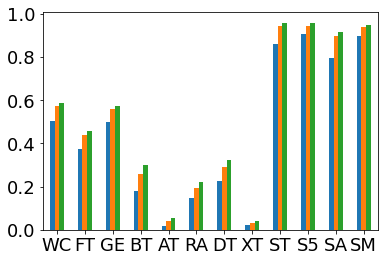

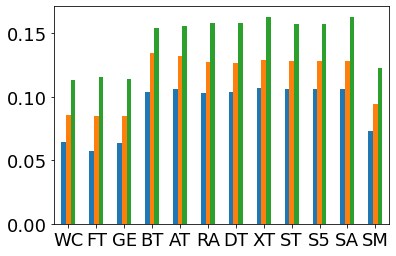

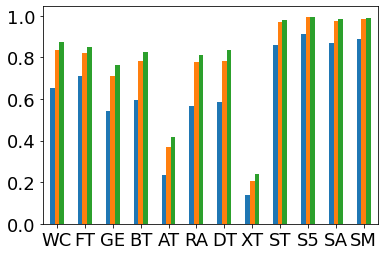

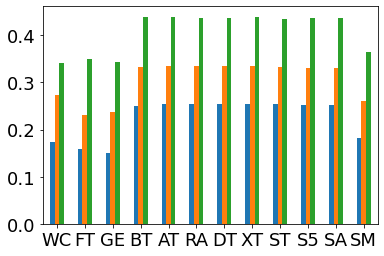

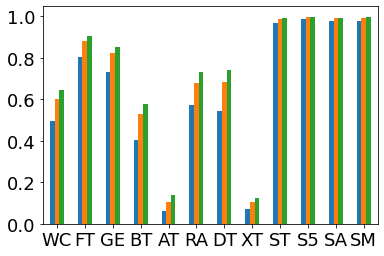

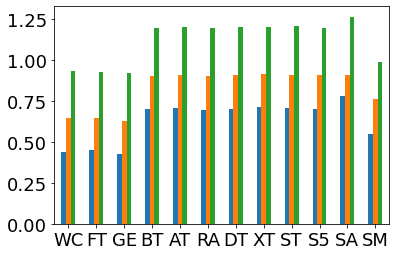

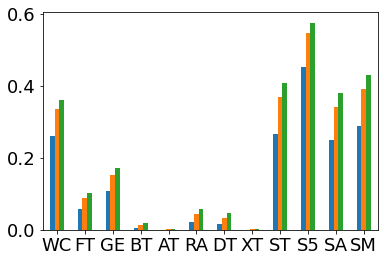

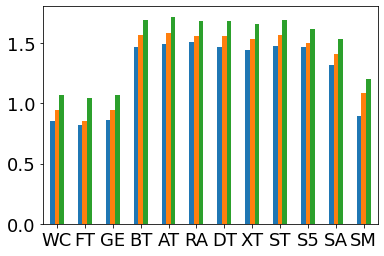

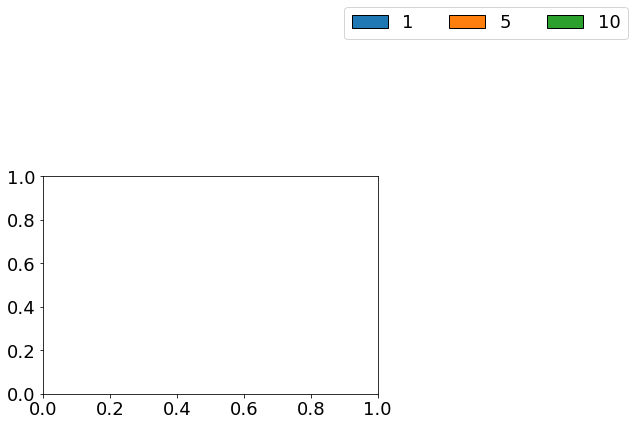

In [11]:
plt.rcParams.update({'font.size': 18, 'font.weight': 'normal'})

block_df2 = filter_df(block_df, [f_agn])
print(block_df2.shape)

#fields = ['Recall', 'Precision', 'Time']
fields = ['Recall', 'Time']

for case in block_df2.Case.unique():
    block_df3 = block_df2[block_df2.Case == case]
        
    for field in fields:
        block_df4 = block_df3.pivot(index='Vectorizer', columns='k', values=field)
        block_df4 = block_df4.loc[vectorizers_order2]
        ax = block_df4.plot(kind='bar', legend=False)
        ax.set_ylabel('')
        ax.set_xlabel('') 
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)        
        
        plt.savefig(f'../plots/blocking_real_{case}_{field}.pdf', bbox_inches='tight')

        
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
ks = [1, 5, 10]

fig = plt.figure()
fig.add_subplot(111)
    
leg = [Patch(facecolor=c, alpha=1.0, label=k, edgecolor='#000') for c, k in zip(colors, ks)]
leg = fig.legend(handles=leg, ncol=len(leg), bbox_to_anchor=(1.5, 1.5))    

expand=[-5,-5,5,5]
fig  = leg.figure
fig.canvas.draw()
bbox  = leg.get_window_extent()
bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
fig.savefig('../plots/blocking_real_legend.pdf', dpi="figure", bbox_inches=bbox)            

## Matching

### Unsupervised

#### Plots

In [12]:
plt.rcParams.update({'font.size': 18, 'font.weight': 'normal'})

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

match_df = pd.read_csv('../logs/matching_unsupervised_euclidean.csv')
match_df['Vectorizer'] = match_df['Vectorizer'].apply(lambda x: x[0]+x[-1]).str.upper()
match_df = match_df.loc[match_df.groupby(['Case', 'Vectorizer'])['F1'].idxmax().values].reset_index(drop=True)

/tmp/ipykernel_59161/839624923.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


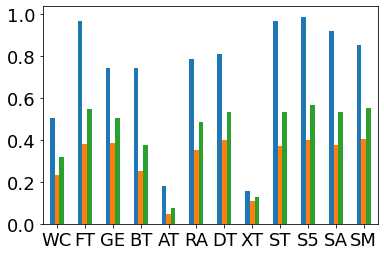

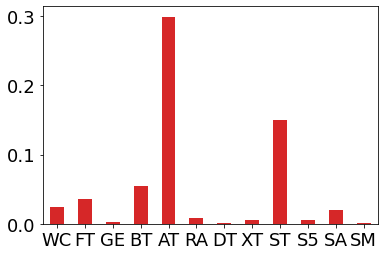

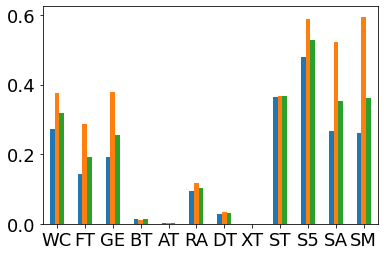

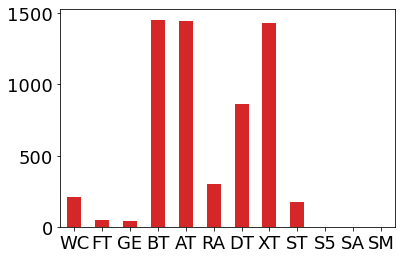

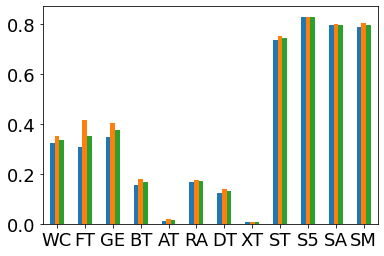

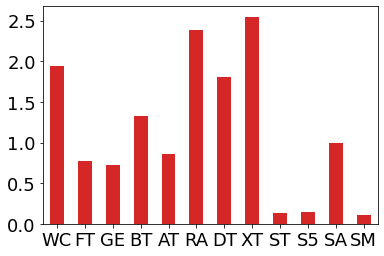

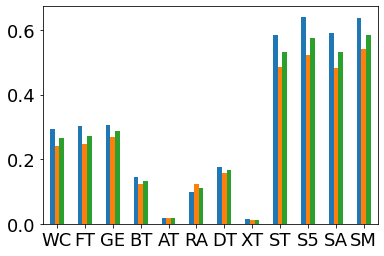

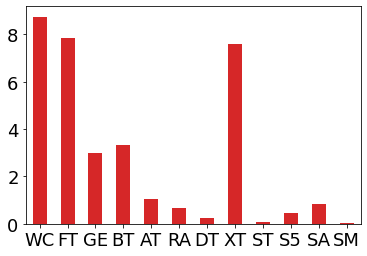

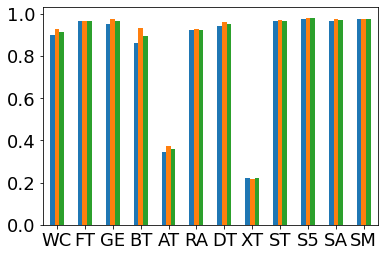

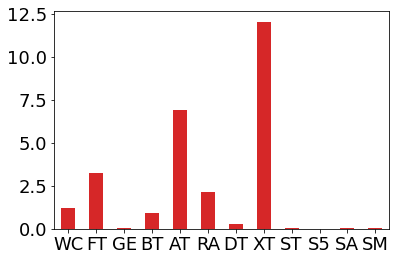

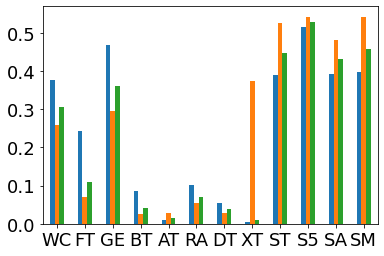

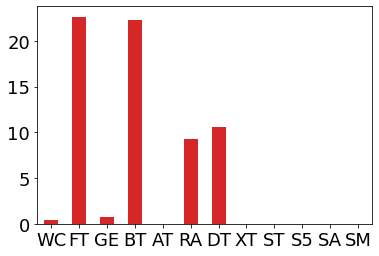

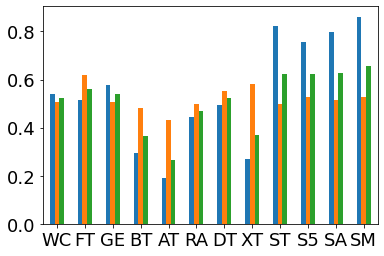

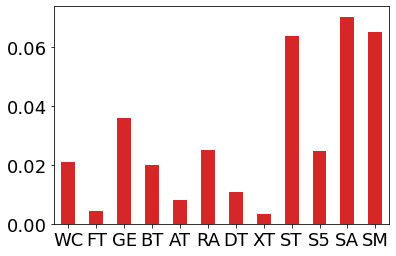

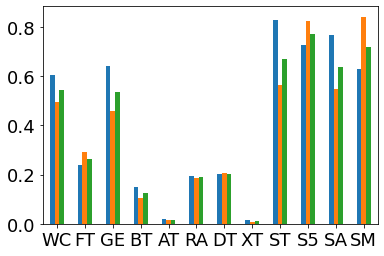

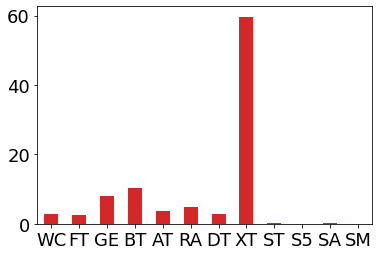

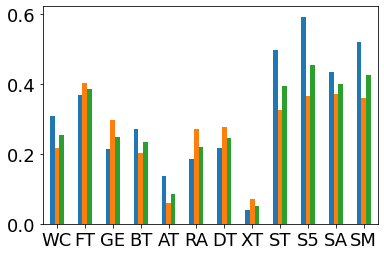

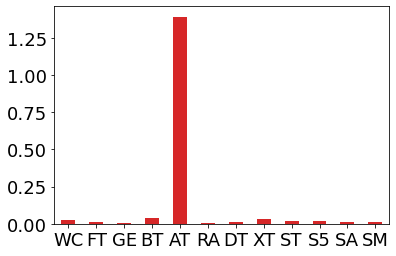

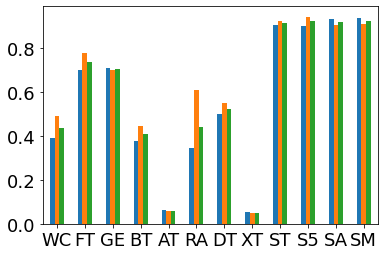

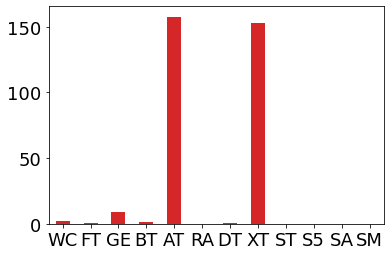

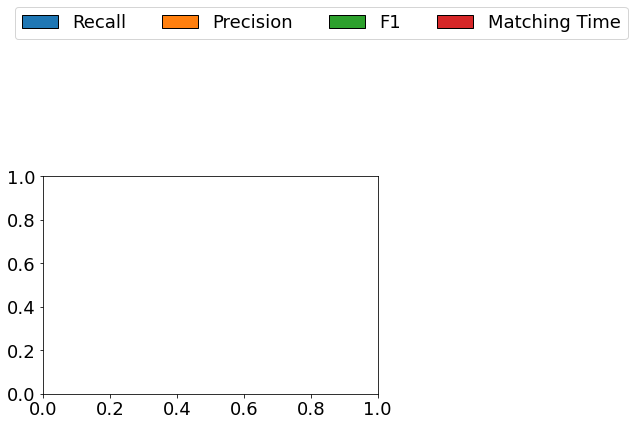

In [13]:
fields = {'scores': ['Recall', 'Precision', 'F1'], 'time': ['Matching Time']}

for case in match_df.Case.unique():
    match_df2 = match_df[match_df.Case == case]
    
    for key, field in fields.items():
        match_df3 = match_df2[field+['Vectorizer']].set_index('Vectorizer')
        match_df3 = match_df3.loc[vectorizers_order2]
        
        if key == 'scores':
            ax = match_df3.plot(kind='bar', legend=False)
        else:
            ax = match_df3.plot(kind='bar', legend=False, color=colors[3])
        ax.set_ylabel('')
        ax.set_xlabel('') 
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)        
        
        plt.savefig(f'../plots/matching_real_{case}_{key}.pdf', bbox_inches='tight')


labels = ['Recall', 'Precision', 'F1', 'Matching Time']

fig = plt.figure()
fig.add_subplot(111)
    
leg = [Patch(facecolor=c, alpha=1.0, label=l, edgecolor='#000') for c, l in zip(colors, labels)]
leg = fig.legend(handles=leg, ncol=len(leg), bbox_to_anchor=(1.5, 1.5))    

expand=[-5,-5,5,5]
fig  = leg.figure
fig.canvas.draw()
bbox  = leg.get_window_extent()
bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
fig.savefig('../plots/matching_real_legend.pdf', dpi="figure", bbox_inches=bbox)    

#### Heatmap

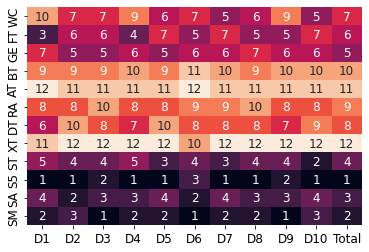

In [14]:
plt.rcParams.update({'font.size': 12, 'font.weight': 'normal'})
heatmap_plot(match_df, 'Case', 'F1', 'Vectorizer', order=case_order)
plt.savefig(f'../plots/matching_unsupervised_heat.pdf', bbox_inches='tight')

#### Correlation

/home/alex/Desktop/repos/Embedings4ER/jupyter/utils.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Total'] = df2.apply(lambda x: (x[col_columns], x[col_values]), axis=1)


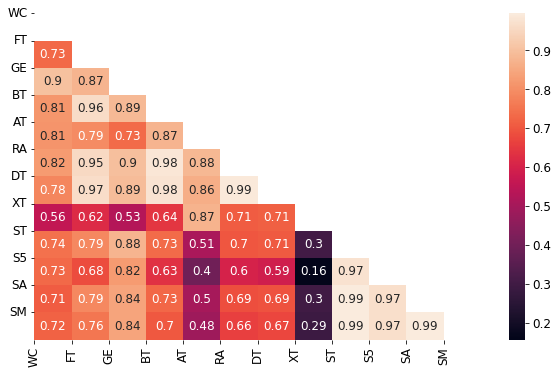

In [15]:
plt.rcParams.update({'font.size': 12, 'font.weight': 'normal'})

corr_plot(match_df, 'Case', 'F1', 'Vectorizer', order=vectorizers_order2, figsize=(10, 6))
plt.savefig(f'../plots/matching_unsupervised_corr.pdf', bbox_inches='tight')
plt.show()

### Supervised

In [16]:
plt.rcParams.update({'font.size': 12, 'font.weight': 'normal'})
with open('../logs/matching_supervised.txt') as f:
    lines = f.readlines()
    lines = [json.loads(line) for line in lines]
match_df_sup = pd.DataFrame(lines)
dirs = {'abt_buy' : 'DSM1', 'dirty_amazon_itunes' : 'DSM2', 'dirty_dblp_acm' : 'DSM3',
        'dirty_dblp_scholar' : 'DSM4', 'dirty_walmart_amazon' : 'DSM5'}

match_df_sup['data_dir'] = match_df_sup['data_dir'].apply(lambda x: dirs[x])
match_df_sup['model_type'] = match_df_sup['model_type'].apply(lambda x: x[0]+x[-1]).str.upper()
print(match_df_sup.shape)

(40, 7)


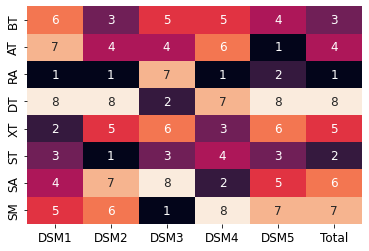

In [17]:
heatmap_plot(match_df_sup, 'data_dir', 'f1', 'model_type')
plt.savefig(f'../plots/matching_supervised_heat.pdf', bbox_inches='tight')

/home/alex/Desktop/repos/Embedings4ER/jupyter/utils.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Total'] = df2.apply(lambda x: (x[col_columns], x[col_values]), axis=1)


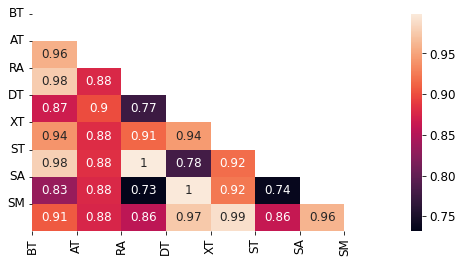

In [18]:
plt.rcParams.update({'font.size': 12, 'font.weight': 'normal'})

vecs = ['BT', 'AT', 'RA', 'DT', 'XT', 'ST', 'SA', 'SM']

corr_plot(match_df_sup, 'data_dir', 'f1', 'model_type', order=vecs, figsize=(8, 4))
plt.savefig(f'../plots/matching_supervised_corr.pdf', bbox_inches='tight')
plt.show()

### Table

In [19]:
dirs = {'abt_buy' : 'DSM1', 'dirty_amazon_itunes' : 'DSM2', 'dirty_dblp_acm' : 'DSM3',
        'dirty_dblp_scholar' : 'DSM4', 'dirty_walmart_amazon' : 'DSM5'}

js = []
with open('../logs/matching_supervised.txt') as f:
    for line in f:
        j = json.loads(line)
        js.append(j)

df = pd.DataFrame(js)
df['data_dir'] = df['data_dir'].apply(lambda x: dirs[x])
df['tt'] = df['training_time']
df['te'] = df['testing_time']

models = ['bert', 'albert', 'roberta', 'distilbert', 'xlnet', 
          'smpnet', 'sdistilroberta', 'sminilm']

df2 = df.pivot(index='model_type', columns='data_dir', values=['f1', 'tt', 'te'])
df2 = df2.loc[models]
df2 = df2[[(col, f'DSM{i}') for i in range(1, 6) for col in ['f1', 'tt', 'te']]]

for index, row in df2.iterrows():
    print(index)
    s = ''
    for no, val in enumerate(row.values):
        if no % 3 == 0:
            s += ' {:.3f} &'.format(val)
        else:
            s += ' {:.2f} &'.format(val)
    print(s[:-1])

bert
 0.843 & 1753.15 & 11.15 & 0.926 & 66.15 & 0.42 & 0.988 & 1521.30 & 9.57 & 0.949 & 2611.11 & 15.76 & 0.819 & 1089.93 & 6.80 
albert
 0.833 & 1687.45 & 11.97 & 0.894 & 62.76 & 0.45 & 0.989 & 1443.84 & 10.32 & 0.948 & 2417.51 & 16.97 & 0.844 & 1023.09 & 7.33 
roberta
 0.866 & 1768.30 & 11.12 & 0.962 & 66.02 & 0.41 & 0.982 & 1543.27 & 9.57 & 0.956 & 2657.20 & 15.69 & 0.831 & 1106.60 & 6.80 
distilbert
 0.817 & 891.34 & 5.52 & 0.792 & 33.92 & 0.21 & 0.991 & 777.94 & 4.76 & 0.947 & 1339.93 & 7.89 & 0.720 & 558.43 & 3.40 
xlnet
 0.864 & 2911.74 & 24.14 & 0.893 & 91.92 & 0.69 & 0.986 & 2117.02 & 15.97 & 0.953 & 3190.81 & 20.78 & 0.760 & 1421.00 & 10.14 
smpnet
 0.862 & 1633.80 & 10.49 & 0.962 & 61.53 & 0.39 & 0.989 & 1404.37 & 8.86 & 0.952 & 2399.82 & 14.35 & 0.824 & 1008.88 & 6.28 
sdistilroberta
 0.861 & 810.67 & 4.99 & 0.830 & 31.33 & 0.19 & 0.980 & 716.91 & 4.31 & 0.956 & 1250.21 & 7.08 & 0.790 & 517.82 & 3.06 
sminilm
 0.857 & 724.24 & 4.21 & 0.857 & 25.43 & 0.15 & 0.992 & 579.85 & 

## Synthetic Data

## Vectorization

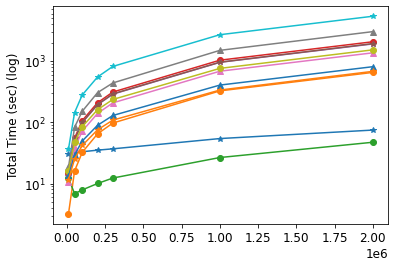

In [20]:
files = ['10K', '50K', '100K', '200K', '300K', '1M', '2M']
markers = ['*', 'o', 'o', 'o', '*', '*', '^', '^', 'o', '*', '^', '*']

with open(input_dir+'vectorization_big.txt') as f:
    lines = []
    for line in f.readlines():
        line = json.loads(line)
        lines.append((line['vectorizer'], line['time'], line['file'], line['memory']['process']['rss']))
    
vec_df2 = pd.DataFrame(lines, columns=['Vectorizer', 'Total Time', 'File', 'Memory Process'])
vec_df2['File'] = vec_df2['File'].apply(lambda x: x.split('.')[0])
vec_df2['File'] = vec_df2['File'].apply(lambda x: int(x[:-1])* (1000 if x[-1] == 'K' else 1000000) )
vec_df2['Vectorizer'] = vec_df2['Vectorizer'].apply(lambda x: x[0]+x[-1]).str.upper()

fig, axes = plt.subplots(nrows=1, ncols=1)
line_plot(vec_df2, 'Vectorizer', 'Total Time', 'File', legend=False,
          ax=axes, markers=markers, yscale='log', ylabel='Total Time (sec) (log)', xlabel='', order=vectorizers_order2)
plt.savefig(f'../plots/vectorization_synthetic_time.pdf', bbox_inches='tight')

## Blocking

In [21]:
files = ['10K.csv', '50K.csv', '100K.csv', '200K.csv', '300K.csv', '1M.csv', '2M.csv']
markers = ['*', 'o', 'o', 'o', '*', '*', '^', '^', 'o', '*', '^', '*']

block_df2 = pd.read_csv('../logs/blocking_recall_euclidean_big.csv')
#results.Case = results.Case.apply(lambda x: files[x].split('.')[0])
block_df2.Case = block_df2.Case.apply(lambda x: files[x])
block_df2['Case'] = block_df2['Case'].apply(lambda x: x.split('.')[0])
block_df2['Case'] = block_df2['Case'].apply(lambda x: int(x[:-1])* (1000 if x[-1] == 'K' else 1000000) )
block_df2['Vectorizer'] = block_df2['Vectorizer'].apply(lambda x: x[0]+x[-1]).str.upper()
print(block_df2.shape)
block_df2 = filter_df(block_df2, [('k', 'eq', 10), f_i2q])
print(block_df2.shape)
block_df2

(84, 9)
(84, 9)


,Case,Columns,Vectorizer,k,Direction,Exact,Recall,Precision,Time
0,10000,2,WC,10,i2q,approx,0.414934,0.042363,0.169578
2,10000,2,GE,10,i2q,approx,0.677082,0.070687,0.199488
3,10000,2,BT,10,i2q,approx,0.404480,0.041353,0.465423
4,10000,2,DT,10,i2q,approx,0.436875,0.046660,0.518980
5,10000,2,RA,10,i2q,approx,0.517978,0.051902,0.540250
...,...,...,...,...,...,...,...,...,...
2,100000,2,FT,10,i2q,approx,0.745383,0.070850,8.306885
3,200000,2,FT,10,i2q,approx,0.664031,0.062374,22.363862
4,300000,2,FT,10,i2q,approx,0.615989,0.056744,37.234016
5,1000000,2,FT,10,i2q,approx,0.475657,0.042570,141.578137


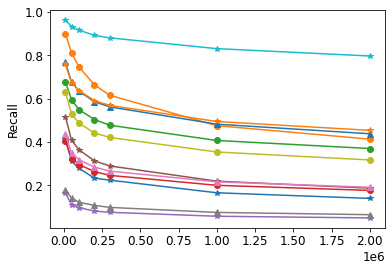

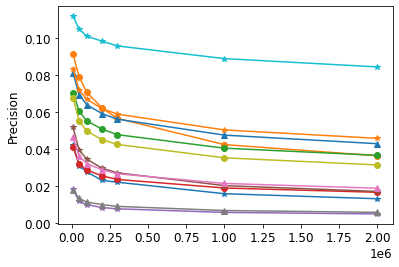

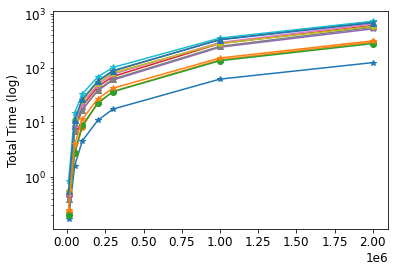

In [22]:
block_df3 = filter_df(block_df2, [f_app])
fig, axes = plt.subplots(nrows=1, ncols=1)
line_plot(block_df3, 'Vectorizer', 'Recall', 'Case', legend=False, markers=markers, ax=axes, title='', order=vectorizers_order2)
plt.savefig(f'../plots/blocking_synthetic_recall_approx.pdf', bbox_inches='tight')

fig, axes = plt.subplots(nrows=1, ncols=1)
line_plot(block_df3, 'Vectorizer', 'Precision', 'Case', legend=False, markers=markers, ax=axes, title='', order=vectorizers_order2)
plt.savefig(f'../plots/blocking_synthetic_precision_approx.pdf', bbox_inches='tight')

fig, axes = plt.subplots(nrows=1, ncols=1)
leg = line_plot(block_df3, 'Vectorizer', 'Time', 'Case', legend=True, markers=markers, ax=axes, title='', yscale='log', ylabel='Total Time (log)', order=vectorizers_order2)
leg.set_visible(False)
plt.savefig(f'../plots/blocking_synthetic_time_approx.pdf', bbox_inches='tight')

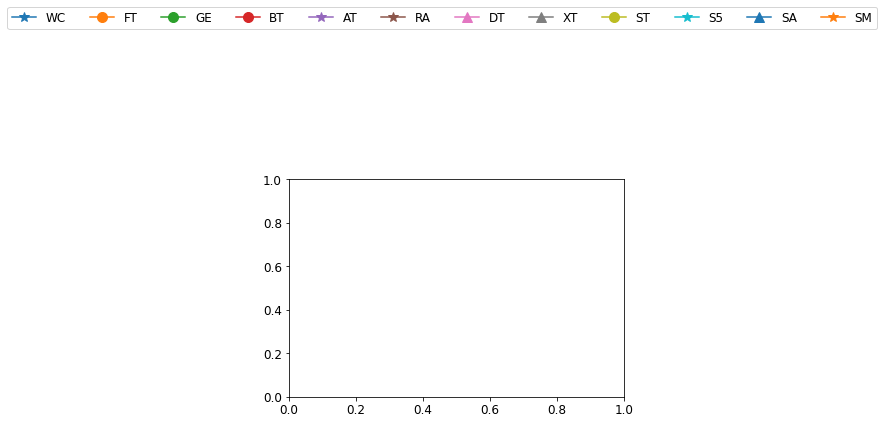

In [23]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig = plt.figure()
fig.add_subplot(111)
    
#leg = [Patch(facecolor=c, alpha=1.0, label=v, edgecolor='#000') for c, v in zip(2*colors, vectorizers_order2)]

leg = [ Line2D([], [], color=c, marker=m, markersize=10, label=v)
         for c, v, m in zip(2*colors, vectorizers_order2, 2*markers)]
leg = fig.legend(handles=leg, ncol=len(leg), bbox_to_anchor=(1.5, 1.5))    
#leg = fig.legend(handles=leg, bbox_to_anchor=(1.5, 1.5))    

leg.set_visible(True)

expand=[-5,-5,5,5]
fig  = leg.figure
fig.canvas.draw()
bbox  = leg.get_window_extent()
bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
fig.savefig('../plots/blocking_synthetic_legend.pdf', dpi="figure", bbox_inches=bbox)    

plt.show()